# Redes Neurais Feedforward (FNN/DNN)

## Nota de aula, 14 de setembro

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data

/Users/marcocristo/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [4]:
mnist = input_data.read_data_sets('data/MNIST_data')

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
print mnist.train.num_examples
print mnist.test.num_examples
print mnist.validation.num_examples

55000
10000
5000


5


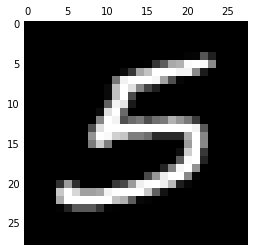

In [6]:
import random
idx = random.randint(1, mnist.train.num_examples)
img = mnist.train.images[idx].reshape((28,28))
plt.matshow(img, cmap = 'gray')
print mnist.train.labels[idx]

In [7]:
class Activation(object):
    """Funcao de ativacao"""
    def __init__(self, name):
        self.name = name
        
    def init(self, n_inputs, n_outputs):
        'Xavier'
        if self.name == 'sigmoid':
            s = np.sqrt(2. / (n_inputs + n_outputs))
            return tf.truncated_normal((n_inputs, n_outputs), 
                                       stddev = s)
        elif self.name == 'relu':
            s = 2. / np.sqrt((n_inputs + n_outputs))
            return tf.truncated_normal((n_inputs, n_outputs), 
                                       stddev = s)
        else:
            return tf.random_uniform([n_inputs, n_outputs], -1.0, 1.0)
        
    def fire(self, ypred):
        if self.name == 'sigmoid':
            return tf.nn.sigmoid(ypred) 
        elif self.name == 'relu':
            return tf.nn.relu(ypred) 
        else:
            return ypred
            
class Layer(object):
    """Camada de rede neural sequencial"""
    def __init__(self, units, activation = None, name = None):
        self.units = units
        self.name = name 
        self.activation = activation if activation != None else Activation('')
        
    def output(self, X):
        n_inputs = int(X.get_shape()[1])
        with tf.name_scope(self.name):
            self.W = tf.Variable(self.activation.init(n_inputs, self.units), name = 'W')
            self.b = tf.Variable(tf.zeros([self.units]), name = 'b')
            ypred = self.activation.fire(tf.matmul(X, self.W) + self.b)
        return ypred

class LossFunction(object):
    def __init__(self, name = 'sigmoid'):
        self.name = name

    def get(self, yreal, ypred):
        if self.name == 'sigmoid':
            loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
                labels = yreal, logits = ypred) 
        return tf.reduce_mean(loss, name = 'lossf')
    
class Optimizer(object):
    def __init__(self, name = 'sgd', lrate = 0.1):
        self.name = name
        self.lrate = lrate

    def get(self, lossf):
        if self.name == 'sgd':
            opt = tf.train.GradientDescentOptimizer(learning_rate = self.lrate) 
        return opt.minimize(lossf)
    
class FeedforwardNeuralNet(object):
    """Rede neural sequencial"""
    def __init__(self, input_dim, lrate = 0.1):
        self.input_dim = input_dim
        self.lrate = lrate
        self.layers = []
        
    def add(self, units, activation = None, name = None):
        """Adiciona camadas para rede neural"""
        self.layers += [Layer(units, activation, name)]
    
    def compile(self, loss = 'sigmoid', optimizer = 'sgd'):
        """Cria grafo da rede neural"""
        self.X = tf.placeholder(tf.float32, 
                           shape = (None, self.input_dim), 
                           name = 'X')
        self.y = tf.placeholder(tf.int64, shape = (None), name = 'y')
        
        # cria layers
        with tf.name_scope('layers'):
            layer_in = self.X
            for layer in self.layers:
                layer_out = layer.output(layer_in)
                layer_in = layer_out
                    
        # loss function
        with tf.name_scope('loss'):
            self.lossf = LossFunction(loss).get(self.y, layer_out)
    
        # optimizer
        with tf.name_scope('train'):
            self.train_op = Optimizer(optimizer, self.lrate).get(self.lossf)
            
        # evalution metrics
        with tf.name_scope('eval'):
            correct = tf.nn.in_top_k(layer_out, self.y, 1)
            self.acc = tf.reduce_mean(tf.cast(correct, tf.float32))
            
        self.init_op = tf.global_variables_initializer()
        self.saver = tf.train.Saver()
    
    def fit(self, train_data, n_epochs, batch_size, val_data = None):
        """Executa treino da rede neural"""
        num_batches = train_data.num_examples // batch_size
        with tf.Session() as s:
            s.run(self.init_op)
            for e in range(n_epochs):
                tloss = 0.
                for i in range(num_batches):
                    X_b, y_b = train_data.next_batch(batch_size)
                    _, loss_e = s.run([self.train_op, self.lossf], 
                                      feed_dict = {self.X: X_b, self.y: y_b})
                    tloss += loss_e
                acc_train = s.run(self.acc, 
                                  feed_dict = {self.X: X_b, self.y: y_b})
                if val_data:
                    acc_val = s.run(self.acc, 
                                    feed_dict = {self.X: val_data.images, 
                                                 self.y: val_data.labels})
                    print '%2d loss: %.8f acct: %.3f accv: %.3f' % (e, 
                                                                    tloss/num_batches, 
                                                                    acc_train, acc_val)
                else:
                    print '%2d loss: %.8f acc: %.3f' % (e, tloss/num_batches, acc_train)
            self.saver.save(s, '/tmp/model.ckpt')
    
    def evaluate(self, X_test, y_test):
        """Avalia rede neural em colecao de teste"""
        with tf.Session() as s:
            self.saver.restore(s, '/tmp/model.ckpt')
            acc_test = s.run(self.acc, 
                             feed_dict = {self.X: X_test, self.y: y_test})
        return acc_test

In [19]:
tf.reset_default_graph()

model = FeedforwardNeuralNet(28 * 28)

model.add(units = 300, activation = Activation('sigmoid'), name = 'h1')
model.add(units = 100, activation = Activation('sigmoid'), name = 'h2')
model.add(units = 10, name = 'out')

model.compile()

In [22]:
model.fit(mnist.train, n_epochs = 10, 
          batch_size = 50, val_data = mnist.validation)

 0 loss: 0.75213411 acct: 0.880 accv: 0.875
 1 loss: 0.37330848 acct: 0.960 accv: 0.900
 2 loss: 0.30337257 acct: 0.860 accv: 0.915
 3 loss: 0.26375390 acct: 0.960 accv: 0.922
 4 loss: 0.23598204 acct: 0.960 accv: 0.930
 5 loss: 0.21503733 acct: 0.960 accv: 0.933
 6 loss: 0.19778006 acct: 0.880 accv: 0.935
 7 loss: 0.18335625 acct: 0.960 accv: 0.941
 8 loss: 0.17090644 acct: 0.900 accv: 0.944
 9 loss: 0.15972942 acct: 0.940 accv: 0.943


In [23]:
model.evaluate(mnist.test.images, mnist.test.labels)

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt


0.94139999

In [28]:
tf.reset_default_graph()

model = FeedforwardNeuralNet(28 * 28)

model.add(units = 300, activation = Activation('sigmoid'), name = 'h1')
model.add(units = 100, activation = Activation('sigmoid'), name = 'h2')
model.add(units = 10, name = 'out')

model.compile()

In [29]:
model.fit(mnist.train, n_epochs = 10, 
          batch_size = 50, val_data = mnist.validation)

 0 loss: 0.62858660 acct: 0.920 accv: 0.909
 1 loss: 0.32681460 acct: 0.940 accv: 0.919
 2 loss: 0.29023756 acct: 0.960 accv: 0.927
 3 loss: 0.26500587 acct: 0.880 accv: 0.929
 4 loss: 0.24366607 acct: 0.960 accv: 0.936
 5 loss: 0.22405101 acct: 0.980 accv: 0.942
 6 loss: 0.20560956 acct: 1.000 accv: 0.947
 7 loss: 0.18955311 acct: 0.980 accv: 0.952
 8 loss: 0.17470819 acct: 0.980 accv: 0.955
 9 loss: 0.16276454 acct: 0.980 accv: 0.958


In [30]:
model.evaluate(mnist.test.images, mnist.test.labels)

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt


0.95249999

In [31]:
tf.reset_default_graph()

model = FeedforwardNeuralNet(28 * 28)

model.add(units = 300, activation = Activation('relu'), name = 'h1')
model.add(units = 100, activation = Activation('relu'), name = 'h2')
model.add(units = 10, name = 'out')

model.compile()

In [32]:
model.fit(mnist.train, n_epochs = 10, 
          batch_size = 50, val_data = mnist.validation)

 0 loss: 0.25013319 acct: 1.000 accv: 0.961
 1 loss: 0.09850866 acct: 1.000 accv: 0.971
 2 loss: 0.06528015 acct: 1.000 accv: 0.973
 3 loss: 0.04335726 acct: 1.000 accv: 0.976
 4 loss: 0.03146065 acct: 1.000 accv: 0.980
 5 loss: 0.02178990 acct: 1.000 accv: 0.978
 6 loss: 0.01501614 acct: 1.000 accv: 0.981
 7 loss: 0.01073761 acct: 1.000 accv: 0.979
 8 loss: 0.00757865 acct: 1.000 accv: 0.982
 9 loss: 0.00511285 acct: 1.000 accv: 0.981


In [33]:
model.evaluate(mnist.test.images, mnist.test.labels)

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt


0.9788

## Nota de aula, 19 de setembro

In [ ]:
# valores de SELU para media 0, desvio 1
# ver paper para detalhes
def selu(z,
         scale = 1.0507009873554804934193349852946,
         alpha = 1.6732632423543772848170429916717):
    return scale * elu(z, alpha)

In [8]:
class Activation(object):
    """Funcao de ativacao"""
    def __init__(self, name):
        self.name = name
        
    def init(self, n_inputs, n_outputs):
        'Xavier'
        if self.name == 'sigmoid':
            s = np.sqrt(2. / (n_inputs + n_outputs))
            return tf.truncated_normal((n_inputs, n_outputs), 
                                       stddev = s)
        elif self.name == 'relu':
            s = 2. / np.sqrt((n_inputs + n_outputs))
            return tf.truncated_normal((n_inputs, n_outputs), 
                                       stddev = s)
        elif self.name == 'selu': ##
            s = np.sqrt(1. / n_inputs)
            return tf.truncated_normal((n_inputs, n_outputs), 
                                       stddev = s)
        else:
            return tf.random_uniform([n_inputs, n_outputs], -1.0, 1.0)
        
    def fire(self, ypred):
        def selu(z, ##
                 scale = 1.0507009873554804934193349852946, 
                 alpha = 1.6732632423543772848170429916717):
            return scale * tf.where(z >= 0.0, z, alpha * tf.nn.elu(z))
        
        if self.name == 'sigmoid':
            return tf.nn.sigmoid(ypred) 
        elif self.name == 'relu':
            return tf.nn.relu(ypred) 
        elif self.name == 'selu':
            return selu(ypred) ## 
        else:
            return ypred

In [9]:
class SNN(FeedforwardNeuralNet):
    """Rede neural sequencial"""
    def __init__(self, input_dim, lrate = 0.1):
        FeedforwardNeuralNet.__init__(self, input_dim, lrate)
           
    def fit(self, train_data, n_epochs, batch_size, val_data = None):
        """Executa treino da rede neural"""
        # obtendo medias e desvios
        self.means = train_data.images.mean(axis=0, keepdims=True)
        self.stds = train_data.images.std(axis=0, keepdims=True) + 1e-10
        
        if val_data:
            X_v_scaled = (val_data.images - self.means) / self.stds ##
            
        num_batches = train_data.num_examples // batch_size
        with tf.Session() as s:
            s.run(self.init_op)
            for e in range(n_epochs):
                tloss = 0.
                for i in range(num_batches):
                    X_b, y_b = train_data.next_batch(batch_size)
                    # escalando dados
                    X_b_scaled = (X_b - self.means) / self.stds ##
                    _, loss_e = s.run([self.train_op, self.lossf], 
                                      feed_dict = {self.X: X_b_scaled, ##
                                                   self.y: y_b})
                    tloss += loss_e
                acc_train = s.run(self.acc, 
                                  feed_dict = {self.X: X_b_scaled, ##
                                               self.y: y_b})
                if val_data:
                    acc_val = s.run(self.acc, 
                                    feed_dict = {self.X: X_v_scaled, ##
                                                 self.y: val_data.labels})
                    print '%2d loss: %.8f acct: %.3f accv: %.3f' % (e, 
                                                                    tloss/num_batches, 
                                                                    acc_train, acc_val)
                else:
                    print '%2d loss: %.8f acc: %.3f' % (e, tloss/num_batches, acc_train)
            self.saver.save(s, '/tmp/model.ckpt')
    
    def evaluate(self, X_test, y_test):
        """Avalia rede neural em colecao de teste"""
        with tf.Session() as s:
            self.saver.restore(s, '/tmp/model.ckpt')
            X_test_s = (X_test - self.means) / self.stds ##
            acc_test = s.run(self.acc, 
                             feed_dict = {self.X: X_test_s, 
                                          self.y: y_test})
        return acc_test

In [10]:
tf.reset_default_graph()

model = SNN(28 * 28)

model.add(units = 300, activation = Activation('selu'), name = 'h1')
model.add(units = 100, activation = Activation('selu'), name = 'h2')
model.add(units = 10, name = 'out')

model.compile()

In [11]:
model.fit(mnist.train, n_epochs = 10, 
          batch_size = 50, val_data = mnist.validation)

 0 loss: 0.84737698 acct: 1.000 accv: 0.942
 1 loss: 0.14276210 acct: 1.000 accv: 0.963
 2 loss: 0.08204656 acct: 1.000 accv: 0.961
 3 loss: 0.07152986 acct: 1.000 accv: 0.974
 4 loss: 0.03958635 acct: 1.000 accv: 0.970
 5 loss: 0.02553944 acct: 1.000 accv: 0.971
 6 loss: 0.01620489 acct: 1.000 accv: 0.970
 7 loss: 0.00816851 acct: 1.000 accv: 0.972
 8 loss: 0.00552846 acct: 1.000 accv: 0.974
 9 loss: 0.00384758 acct: 1.000 accv: 0.972


In [12]:
model.evaluate(mnist.test.images, mnist.test.labels)

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt


0.97469997

In [18]:
class Optimizer(object):
    def __init__(self, name = 'sgd', lrate = 0.1):
        self.name = name
        self.lrate = lrate

    def get(self, lossf):
        if self.name == 'sgd':
            opt = tf.train.GradientDescentOptimizer(learning_rate = self.lrate) 
        elif self.name == 'adam':
            opt = tf.train.AdamOptimizer() 
        return opt.minimize(lossf)

In [19]:
tf.reset_default_graph()

model = FeedforwardNeuralNet(28 * 28)

model.add(units = 300, activation = Activation('relu'), name = 'h1')
model.add(units = 100, activation = Activation('relu'), name = 'h2')
model.add(units = 10, name = 'out')

model.compile(optimizer = 'adam')

In [20]:
model.fit(mnist.train, n_epochs = 10, 
          batch_size = 50, val_data = mnist.validation)

 0 loss: 0.22260752 acct: 0.980 accv: 0.961
 1 loss: 0.09181031 acct: 0.980 accv: 0.974
 2 loss: 0.06231435 acct: 0.960 accv: 0.975
 3 loss: 0.04749824 acct: 0.980 accv: 0.979
 4 loss: 0.03818032 acct: 1.000 accv: 0.978
 5 loss: 0.03061841 acct: 0.980 accv: 0.981
 6 loss: 0.02923365 acct: 1.000 accv: 0.974
 7 loss: 0.02118843 acct: 1.000 accv: 0.978
 8 loss: 0.02163228 acct: 1.000 accv: 0.979
 9 loss: 0.01913158 acct: 1.000 accv: 0.978


In [21]:
model.evaluate(mnist.test.images, mnist.test.labels)

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt


0.97689998

In [25]:
def compile(self, loss = 'sigmoid', optimizer = 'sgd', 
            dropout_rate = 0.0):
    """Cria grafo da rede neural"""
    self.X = tf.placeholder(tf.float32, 
                       shape = (None, self.input_dim), 
                       name = 'X')
    self.y = tf.placeholder(tf.int64, shape = (None), name = 'y')
    ## dropout
    self.training = tf.placeholder_with_default(False, shape = (),
                                                name = 'training')

    # cria layers
    with tf.name_scope('layers'):
        if dropout_rate == 0.0:
            layer_in = self.X
        else:
            layer_in = tf.layers.dropout(self.X, dropout_rate, 
                                         self.training)
        for layer in self.layers:
            if dropout_rate == 0.0:
                layer_out = layer.output(layer_in)
            else:
                layer_out = tf.layers.dropout(layer.output(layer_in), 
                                              dropout_rate, self.training)
            layer_in = layer_out

    # loss function
    with tf.name_scope('loss'):
        self.lossf = LossFunction(loss).get(self.y, layer_out)

    # optimizer
    with tf.name_scope('train'):
        self.train_op = Optimizer(optimizer, self.lrate).get(self.lossf)

    # evalution metrics
    with tf.name_scope('eval'):
        correct = tf.nn.in_top_k(layer_out, self.y, 1)
        self.acc = tf.reduce_mean(tf.cast(correct, tf.float32))

    self.init_op = tf.global_variables_initializer()
    self.saver = tf.train.Saver()

def fit(self, train_data, n_epochs, batch_size, val_data = None):
    """Executa treino da rede neural"""
    num_batches = train_data.num_examples // batch_size
    with tf.Session() as s:
        s.run(self.init_op)
        for e in range(n_epochs):
            tloss = 0.
            for i in range(num_batches):
                X_b, y_b = train_data.next_batch(batch_size)
                _, loss_e = s.run([self.train_op, self.lossf], 
                                  feed_dict = {self.X: X_b, 
                                               self.y: y_b,
                                               self.training: True})
                tloss += loss_e
            acc_train = s.run(self.acc, 
                              feed_dict = {self.X: X_b, self.y: y_b})
            if val_data:
                acc_val = s.run(self.acc, 
                                feed_dict = {self.X: val_data.images, 
                                             self.y: val_data.labels})
                print '%2d loss: %.8f acct: %.3f accv: %.3f' % (e, 
                                                                tloss/num_batches, 
                                                                acc_train, acc_val)
            else:
                print '%2d loss: %.8f acc: %.3f' % (e, tloss/num_batches, acc_train)
        self.saver.save(s, '/tmp/model.ckpt')
    
FeedforwardNeuralNet.fit = fit
FeedforwardNeuralNet.compile = compile

In [30]:
tf.reset_default_graph()

model = FeedforwardNeuralNet(28 * 28)

model.add(units = 300, activation = Activation('relu'), name = 'h1')
model.add(units = 100, activation = Activation('relu'), name = 'h2')
model.add(units = 10, name = 'out')

model.compile(optimizer = 'adam', dropout_rate = 0.5)

In [31]:
model.fit(mnist.train, n_epochs = 10, 
          batch_size = 50, val_data = mnist.validation)

 0 loss: 0.21772785 acct: 0.960 accv: 0.970
 1 loss: 0.09097756 acct: 1.000 accv: 0.975
 2 loss: 0.06324646 acct: 0.980 accv: 0.977
 3 loss: 0.05019373 acct: 1.000 accv: 0.979
 4 loss: 0.03827936 acct: 1.000 accv: 0.978
 5 loss: 0.03419658 acct: 1.000 accv: 0.976
 6 loss: 0.02871753 acct: 1.000 accv: 0.976
 7 loss: 0.02164480 acct: 1.000 accv: 0.977
 8 loss: 0.02378546 acct: 1.000 accv: 0.980
 9 loss: 0.01958281 acct: 1.000 accv: 0.982


In [32]:
model.evaluate(mnist.test.images, mnist.test.labels)

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt


0.97820002

## Notas de aula 21 de setembro

### Keras

In [3]:
import keras

Using TensorFlow backend.


In [4]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization

In [5]:
from tensorflow.examples.tutorials.mnist import input_data

In [6]:
mnist = input_data.read_data_sets('data/MNIST_data', one_hot = True)

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [12]:
model = Sequential()

model.add(Dense(units = 250, input_dim = 28*28, activation = 'relu'))
model.add(Dense(units = 10, activation = 'softmax'))

In [13]:
model.compile(loss = 'categorical_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

In [14]:
trmodel = model.fit(mnist.train.images,  # X_train
                    mnist.train.labels,  # y_train
                    epochs = 5,        
                    batch_size = 128,
                    validation_data = (mnist.validation.images, # X_val
                                       mnist.validation.labels)  # y_val
                   )

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 3s - loss: 0.3204 - acc: 0.9101 - val_loss: 0.1623 - val_acc: 0.9586
Epoch 2/5
55000/55000 [==============================] - 3s - loss: 0.1405 - acc: 0.9590 - val_loss: 0.1127 - val_acc: 0.9680
Epoch 3/5
55000/55000 [==============================] - 3s - loss: 0.0964 - acc: 0.9718 - val_loss: 0.1016 - val_acc: 0.9708
Epoch 4/5
55000/55000 [==============================] - 3s - loss: 0.0731 - acc: 0.9789 - val_loss: 0.0884 - val_acc: 0.9730
Epoch 5/5
55000/55000 [==============================] - 3s - loss: 0.0563 - acc: 0.9839 - val_loss: 0.0828 - val_acc: 0.9748


# Redes de Convolução

In [16]:
from PIL import Image
import skimage.measure 

In [21]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
def reset_graph(seed = 42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
def plot_figs(lst):
    if len(lst) == 1:
        plt.matshow(lst[0], cmap = 'gray', interpolation = 'nearest')
    else:
        f, axes = plt.subplots(1, len(lst))
        for i, a in enumerate(axes):
            a.matshow(lst[i], cmap = 'gray', interpolation = 'nearest')
            a.set(aspect = 'equal')

### Convoluções

In [28]:
ex0 = np.array([[0,0,0,1,0,0,0,0],
                [0,0,1,0,0,0,0,0],
                [0,1,0,0,0,0,0,0],
                [1,0,0,0,0,0,0,0],
                [0,0,0,0,1,0,0,0],
                [0,0,0,0,0,1,0,0],
                [0,0,0,0,0,0,1,0],
                [0,0,0,0,0,0,0,1]])
ex1 = np.array([[0,0,0,0,0,0,0,1],
                [0,0,0,0,0,0,0,1],
                [0,0,0,0,0,0,1,0],
                [0,0,0,0,0,0,1,0],
                [0,0,0,0,0,1,0,0],
                [0,0,0,0,0,1,0,0],
                [0,0,0,0,1,0,0,0],
                [0,0,0,0,1,0,0,0]])
k0 = np.array([[0,0,0,1],
               [0,0,1,0],
               [0,1,0,0],
               [1,0,0,0]])

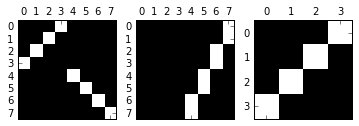

In [29]:
plot_figs([ex0, ex1, k0])

In [30]:
def conv0(a1, a2):
    sigmoid = lambda n: 1. / (1 + np.exp(-n))
    a1r = a1.reshape((-1, 1))
    a2r = a2.reshape((-1, 1))
    return sigmoid(np.sum(np.multiply(a1r, a2r)))

0.98201379003790845

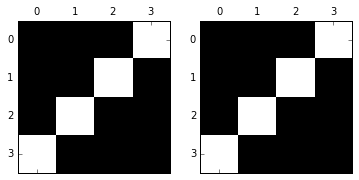

In [32]:
plot_figs([ex0[:4, :4], k0])
conv0(ex0[:4,:4], k0)